In [2]:
from comet_ml import Experiment
experiment = Experiment(api_key="9V1gFeumyguS3tXr1fcTnoOAM", project_name="general", workspace="cottrell")

COMET ERROR: Failed to log git metadata
COMET ERROR: Failed to log git patch
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/cottrell/general/900e2023a68a48e9baa807df91371dcf



In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
# https://stackoverflow.com/questions/44544766/how-do-i-check-if-keras-is-using-gpu-version-of-tensorflow
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# confirm PyTorch sees the GPU
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0
print(cuda.get_device_name(cuda.current_device()))

GeForce RTX 2070


Using TensorFlow backend.


In [5]:
# for some reason this breaks something when it runs first!?
import tensorflow as tf
print("cuda_only=False", tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))
print("cuda_only=True", tf.test.is_gpu_available(cuda_only=True, min_cuda_compute_capability=None))

cuda_only=False True
cuda_only=True True


In [6]:
%matplotlib inline
from pandas_datareader import data as pdr
import datetime
import fix_yahoo_finance as yf
from ratelimit import limits, sleep_and_retry
import sklearn.preprocessing as skp
from joblib import Memory
import os
import time
from pylab import *
_mydir = '.'

cachedir = os.path.join(_mydir, 'joblib_cache')
memory = Memory(cachedir, verbose=1)

yf.pdr_override()
_period_seconds = 1
@memory.cache
@sleep_and_retry
@limits(calls=1, period=_period_seconds)
def _get_data_yahoo(names, start, end):
    return pdr.get_data_yahoo(names, start=start, end=end)

def get_data_yahoo(names, start, end):
    df = _get_data_yahoo(names, start, end)
    if len(names) > 1:
        df = df.stack()
        df.index.names = ['date', 'name']
    else:
        df['name'] = names[0]
    df = df.reset_index()
    df.columns = [x.lower().replace(' ', '_') for x in df.columns]
    return df


names = ['soxx', 'spy', 'aapl', 'noc', 'gs']
start = datetime.date(2010, 1, 1)
end = datetime.date(2018, 11, 1)

data = get_data_yahoo(names, start, end)
data = data.sort_values(by='date')
data.shape

dates = data.date.unique()
dates.sort()
test_frac = 0.2
date_test = dates[int(len(dates) * (1 - test_frac))]
def split_data_by_date(data, date):
    i = data.date < date
    data_train = data[i]
    data_test = data[~i]
    print(data_train.shape, data_test.shape)
    return data_train, data_test

# one now for now
name = 'NOC'
data_train, data_test = split_data_by_date(data[data.name == name], date_test)

# do NO transformations for now, will be weird
xcols = ['adj_close', 'close', 'high', 'low', 'open', 'volume']
ycols = ['adj_close'] # shifted obviosly
pcols = ['adj_close', 'close', 'high', 'low', 'open']
output_dim = len(ycols)

def lagger(df, periods=[1]):
    d = list()
    for x in periods:
        temp = df.shift(periods=x)
        temp.columns = ['{}_lag{}'.format(k, x) for k in temp.columns] 
        d.append(temp)
    return pd.concat(d, axis=1)

d = lagger(data[xcols], periods=[1, 2, 3, 5, 10])

def getxy(data):
    assert data.name.nunique() == 1, 'you need to change the code if you do this'
    # watch out for overflow etc, TODO norm
    data = data.copy()
    data[pcols] = np.log(data[pcols]).diff()
    data = data.iloc[1:]
    
    t = skp.QuantileTransformer(output_distribution='normal')
#     t = skp.MinMaxScaler()
    
    t.fit(data[pcols])
    data[pcols] = t.transform(data[pcols])
    
    lags = [1, 2, 3, 5, 10]
    X = lagger(data[xcols], lags)
    X = pd.concat([data[xcols], X], axis=1)
    xcols_with_lags = list(X.columns)

    predict_steps = 1
    # numpy arrays after this step
    y = data.shift(periods=-predict_steps)[ycols].values
    X = X.values
    
    X = X[max(lags):-predict_steps]
    y = y[max(lags):-predict_steps]
    
    # add some lag features
    assert not np.any(np.isnan(X))
    assert not np.any(np.isnan(y))
    return X, y, xcols_with_lags

X_train, y_train, xcols_enriched = getxy(data_train)
X_test, y_test, _ = getxy(data_test)
X_train.shape, y_train.shape

input_dim = X_train.shape[1]

(1779, 8) (445, 8)


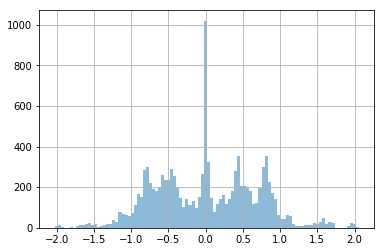

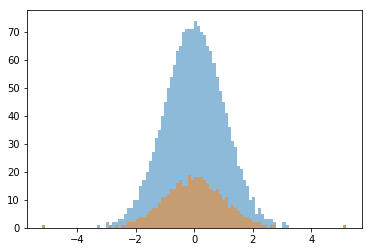

In [7]:
_ = np.log(data.adj_close).diff().dropna().hist(bins=100, alpha=0.5)

figure()
_ = hist(y_train, bins=100, alpha=0.5)
_ = hist(y_test, bins=100, alpha=0.5)


In [8]:
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.layers import Dense, Dropout
import tensorflow.keras.optimizers as optimizers
import tensorflow.layers as layers
import tensorflow as tf

# does not work?
# https://stackoverflow.com/questions/47877475/keras-tensorboard-plot-train-and-validation-scalars-in-a-same-figure

tboard = keras.callbacks.TensorBoard(log_dir="runs/keras-{}".format(time.time()))

In [9]:
# for example https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

def create_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, kernel_initializer='normal', activation='relu')),
    model.add(Dense(32, kernel_initializer='normal', activation='relu')),
    model.add(Dense(output_dim, kernel_initializer='normal', activation='linear'))
    opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

model_filename = 'keras_playground.hdf5'
if os.path.exists(model_filename):
    print('loading {}'.format(model_filename))
    model = keras.models.load_model(model_filename)
else:
    model = create_model()    

loading keras_playground.hdf5


In [10]:
# fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None,
# validation_split=0.0, validation_data=None, shuffle=True, class_weight=None,
# sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None,
# max_queue_size=10, workers=1, use_multiprocessing=False, **kwargs)
model.fit(X_train, y_train.squeeze(), epochs=10, steps_per_epoch=10000, verbose=1, validation_steps=100, validation_data=(X_test, y_test.squeeze()), callbacks=[tboard])
model.save('keras_playground.hdf5')

Epoch 1/10
 2603/10000 [======>.......................] - ETA: 11s - loss: 29.7977

KeyboardInterrupt: 

In [75]:
y_train_p = model.predict(X_train).squeeze()
y_test_p = model.predict(X_test).squeeze()

# ugh put it back together for seaborn
def putbacktogetheragain(X, y, yp, label, xcols=xcols_enriched, ycols=ycols):
    X = pd.DataFrame(X, columns=xcols)
    y = pd.DataFrame(y, columns=ycols)
    yp = pd.DataFrame(yp, columns=['{}_pred'.format(x) for x in ycols])
    df = pd.concat([y, yp, X], axis=1)
    df['val_label'] = label
    return df

df = putbacktogetheragain(X_train, y_train.squeeze(), y_train_p, 'train')
df.head()

,adj_close,adj_close_pred,adj_close,close,high,low,open,volume,adj_close_lag1,close_lag1,high_lag1,low_lag1,open_lag1,volume_lag1,adj_close_lag2,close_lag2,high_lag2,low_lag2,open_lag2,volume_lag2,adj_close_lag3,close_lag3,high_lag3,low_lag3,open_lag3,volume_lag3,adj_close_lag5,close_lag5,high_lag5,low_lag5,open_lag5,volume_lag5,adj_close_lag10,close_lag10,high_lag10,low_lag10,open_lag10,volume_lag10,val_label
0,-2.158387,0.089558,-1.115688,-1.110184,-1.501286,-1.162003,-0.403306,1858600.0,0.438993,0.443501,0.697016,-0.048755,-0.791402,2460200.0,-1.145025,-1.139084,-1.207459,-0.899651,-0.399716,1846800.0,-0.110076,-0.094655,0.456539,1.299334,1.943431,2044300.0,-0.011539,0.001248,-0.836808,-0.833300,-0.881274,1650500.0,0.045859,0.056931,1.023212,0.945495,0.891710,1859800.0,train
1,-1.644668,-0.227520,-2.158387,-2.148430,-0.849376,-1.539864,-0.542008,2682100.0,-1.115688,-1.110184,-1.501286,-1.162003,-0.403306,1858600.0,0.438993,0.443501,0.697016,-0.048755,-0.791402,2460200.0,-1.145025,-1.139084,-1.207459,-0.899651,-0.399716,1846800.0,2.099151,2.099153,2.416606,1.505465,0.747261,2729700.0,0.270839,0.280904,-0.569801,-0.363865,0.057806,2204900.0,train
2,0.007131,0.603474,-1.644668,-1.634824,-2.096839,-1.692433,-1.908056,2182900.0,-2.158387,-2.148430,-0.849376,-1.539864,-0.542008,2682100.0,-1.115688,-1.110184,-1.501286,-1.162003,-0.403306,1858600.0,0.438993,0.443501,0.697016,-0.048755,-0.791402,2460200.0,-0.110076,-0.094655,0.456539,1.299334,1.943431,2044300.0,0.909523,0.910836,1.264431,0.132508,0.087949,4750900.0,train
3,0.477806,0.033649,0.007131,0.022871,-1.229464,-0.488081,-0.922248,2499100.0,-1.644668,-1.634824,-2.096839,-1.692433,-1.908056,2182900.0,-2.158387,-2.148430,-0.849376,-1.539864,-0.542008,2682100.0,-1.115688,-1.110184,-1.501286,-1.162003,-0.403306,1858600.0,-1.145025,-1.139084,-1.207459,-0.899651,-0.399716,1846800.0,-0.671730,-0.660816,0.221082,0.689228,0.673016,1723700.0,train
4,1.121142,-0.157085,0.477806,0.483039,0.351969,-0.280904,-1.054619,2079300.0,0.007131,0.022871,-1.229464,-0.488081,-0.922248,2499100.0,-1.644668,-1.634824,-2.096839,-1.692433,-1.908056,2182900.0,-2.158387,-2.148430,-0.849376,-1.539864,-0.542008,2682100.0,0.438993,0.443501,0.697016,-0.048755,-0.791402,2460200.0,-0.011206,0.001973,-0.411538,-0.047729,0.543806,1523000.0,train


In [135]:
(np.random.randn(5,1)[:,:,np.newaxis] + np.eye(5)[:,np.newaxis,:]).squeeze().shape

(5, 5)

In [130]:
np.eye(5)[:,np.newaxis,:].shape

(5, 1, 5)

In [129]:
np.random.randn(5,2).shape

(5, 2)

In [138]:
def approx_fprime(f, epsilon=1e-6):
    def fp(x, epsilon=epsilon):
        dx = np.eye(x.shape[0]) * epsilon
#         dx = dx[:,np.newaxis,:]
#         x = x[:,:,np.newaxis]
        f1 = f(x + dx)
        f0 = f(x)
        fp = (f1 - f0) / dx
        return fp.squeeze()
    return fp



fp = approx_fprime(model.predict)
fp(np.zeros((1, X_train.shape[1])))

array(0.20459993)

In [77]:
# # apparently is hard: https://github.com/tensorflow/tensorflow/issues/675
# def Jacobian(X, y):
#     J = tf.map_fn(lambda m: tf.gradients(y[:,m:m+1], X)[0], tf.range(tf.shape(y)[-1]), tf.float32)
#     J = tf.transpose(tf.squeeze(J), perm = [1,0])
#     return J

(array([-5.19933758]), array([5.19933758]))

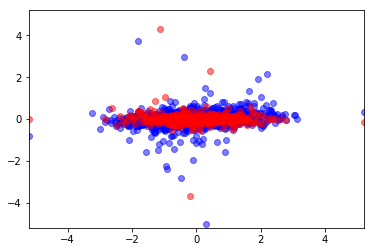

In [78]:

plot(y_train.squeeze(), y_train_p, 'bo', alpha=0.5)
plot(y_test.squeeze(), y_test_p, 'ro', alpha=0.5)
xlim(min(y_test), max(y_test))
ylim(min(y_test), max(y_test))

# figure()
# j = 0
# itr = 
# plot(X_train[:,j], y_train.squeeze(), 'b', alpha=0.5)
# plot(X_test[:,j], y_test.squeeze(), 'r', alpha=0.5)

In [39]:
df.shaped

NameError: name 'df' is not defined